# ASTR 596: FDS - The Midterm

### Dun, dun dun. 
#### (suspenseful music here)

## Start with the Cepheid data you have already seen in lecture 03 and 04.

## There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

## Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file.

In [99]:
exec(open('cepheids.py').read())
ceph = Cepheids('../../../data/03/R11ceph.dat')
hosts = ceph.list_hosts()
for n in hosts:
    print(n)

1309
3021
3370
3982
4038
4258
4536
4639
5584


In [100]:
import pandas as pd
data=pd.DataFrame(ceph.data)
print(data)

            0       1        2     3       4     5     6
0     27185.0  4536.0  24.5123  0.31  13.000 -3.46  0.13
1     42353.0  4536.0  25.9907  0.74  13.070 -3.03  0.37
2     50718.0  4536.0  24.1492  0.42  13.730 -3.36  0.28
3     72331.0  4536.0  24.4751  0.44  13.910 -3.19  0.22
4     65694.0  4536.0  24.8582  0.38  14.380 -3.10  0.39
..        ...     ...      ...   ...     ...   ...   ...
641   29163.0  4258.0  24.1520  0.57   6.739 -3.25  0.38
642   34729.0  4258.0  22.6608  0.50  14.920 -3.25  0.00
643   89375.0  4258.0  22.4128  0.45  12.380 -3.11  0.42
644  246695.0  4258.0  22.5969  0.40  11.200 -3.11  0.49
645  312665.0  4258.0  22.7720  0.11  39.090 -3.22  0.01

[646 rows x 7 columns]


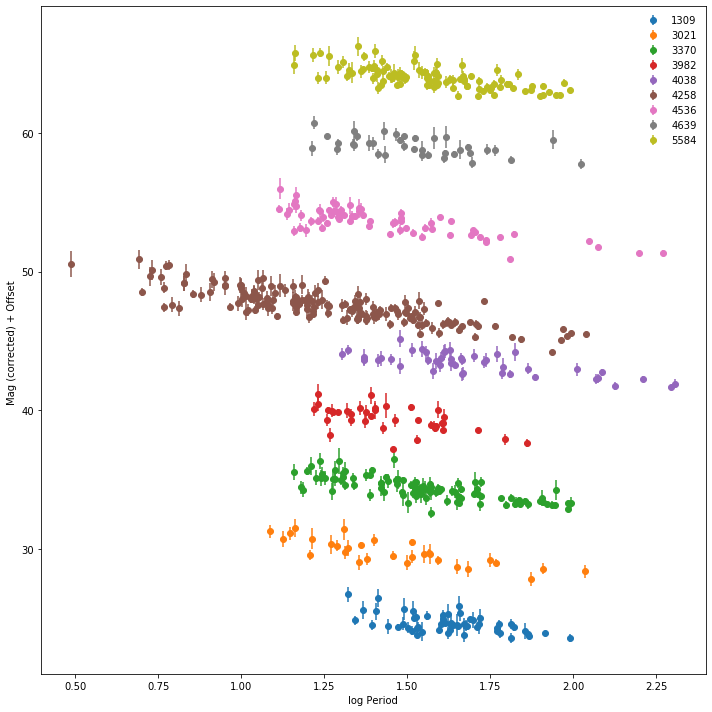

In [101]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


In [102]:
import numpy as np

def likelihood(i, s, sig_int=0.5, ceph=ceph):
    # i is the array for the intercept of the data, in this case it is the mu in the equation
    # s is the slope of the linear fit to the data, which is a floating point number
    # sig_int is the gaussian intrinsic dispersion
    
    l=[]
    for j, ID in enumerate(hosts):
        ceph.select(ID)
        mobs = ceph.mobs
        logP = ceph.logP
        sigma_obs = ceph.sigma
        
        # the following is the expression for the likelihood function
        l.append(np.mean(np.exp(-(mobs-(i[j]-i[5]+ceph.redshifts['4258']+s*logP))**2/(2*(sigma_obs**2+sig_int**2)))))
    
    l_t=np.mean(l)
    
    return l_t

In [103]:
i=np.ones(len(ceph.list_hosts()))
s=-1
print(likelihood(i,s))

2.6792154235387534e-138


# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

In [104]:
# there are 3 parameter that we can restrain by applying a prior: the intercept, the slope, 
# and the intrinsic gaussian dispersion

# the intercept can be estimated with the redshift data from ceph
# to estimate distance from redshift, we will need an guess for the Hubble constant
# We can make that guess 70, since this is a multiple of 10 which is pleasing to the eye 
# and also a conprimise between different published estimates of the constant
# (plus a habit of mine formed by the astro classes here since most professor use 70 as default values for problems)

mag_est=np.zeros(len(ceph.list_hosts()))
H0=70
c = 3*10**5 # unit conversion is an easy mistake to make, this is in unit of km/s 
for j, ID in enumerate(ceph.list_hosts()):
    vel = ceph.redshifts[ID]*c 
    dis = vel/H0*10**6 # in unit of pc
    mag_est[j] = 5 * np.log10(dis/10)
print('These will be our estimate of offsets:') 
#print(ceph.redshifts)
print(mag_est)
    
# the slope can be guess by observation
# it is a negative number for sure
# a gaussian around a mean of , let's say -2.5 
# (an estimate by human observation, so sadly not physically motivated)
s=np.random.normal(loc=-2.5,scale=1.0) # only an example, not how we are actually doing it

# the intrinsic dispersion is a wild card, since I don't have an idea about what it is.
# we will choose 0.5 for now and let the model decide

These will be our estimate of offsets:
[32.42404042 31.71493167 31.31022033 31.00053773 31.85282978 29.03186906
 32.06206272 30.81431497 31.84766953]


# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [105]:
import pymc3 as pm

In [69]:
# test run with one dataset

ceph.select(ceph.list_hosts()[5])
logP = ceph.logP
sig = ceph.sigma
mag_obs = ceph.mobs
sig_int_est=0.5

zpw = ceph.redshifts['4258']
vel = zpw*c 
dis = vel/H0*10**6 # in unit of pc
zpw = 5 * np.log10(dis/10)

with pm.Model() as model:
    s = pm.Normal('s', mu=-2.5, sigma=1, shape=1)
    
    mag=pm.Normal('mag', mu=mag_est[5], sigma=sig)
    
    sig_int=pm.TruncatedNormal('sig_int',mu=sig_int_est,sigma=1,lower=0.0)
    
    model = mag + s*(logP)
    
    likelihood=pm.Normal('likelihood', mu=model, sigma=np.sqrt(sig**2 + sig_int**2), observed=mag_obs)
    
    samples_g = pm.sample(10000,cores=4)
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig_int, mag, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:16<00:00, 2607.83draws/s]


/home/thirty-oner/anaconda3/envs/fds/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/thirty-oner/anaconda3/envs/fds/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/thirty-oner/anaconda3/envs/fds/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee7643b128>,
      dtype=object)

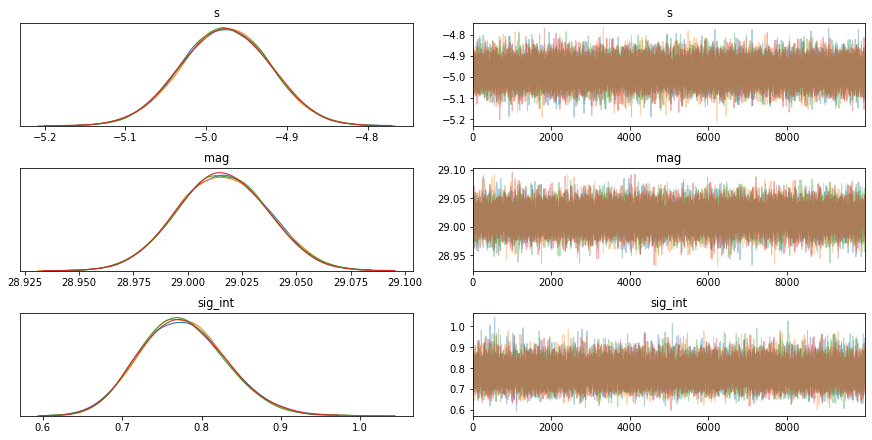

In [70]:
pm.traceplot(samples_g)

/home/thirty-oner/anaconda3/envs/fds/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/pairplot.py:90: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 9x9 grid
  SyntaxWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1342f61b38>,
      dtype=object)

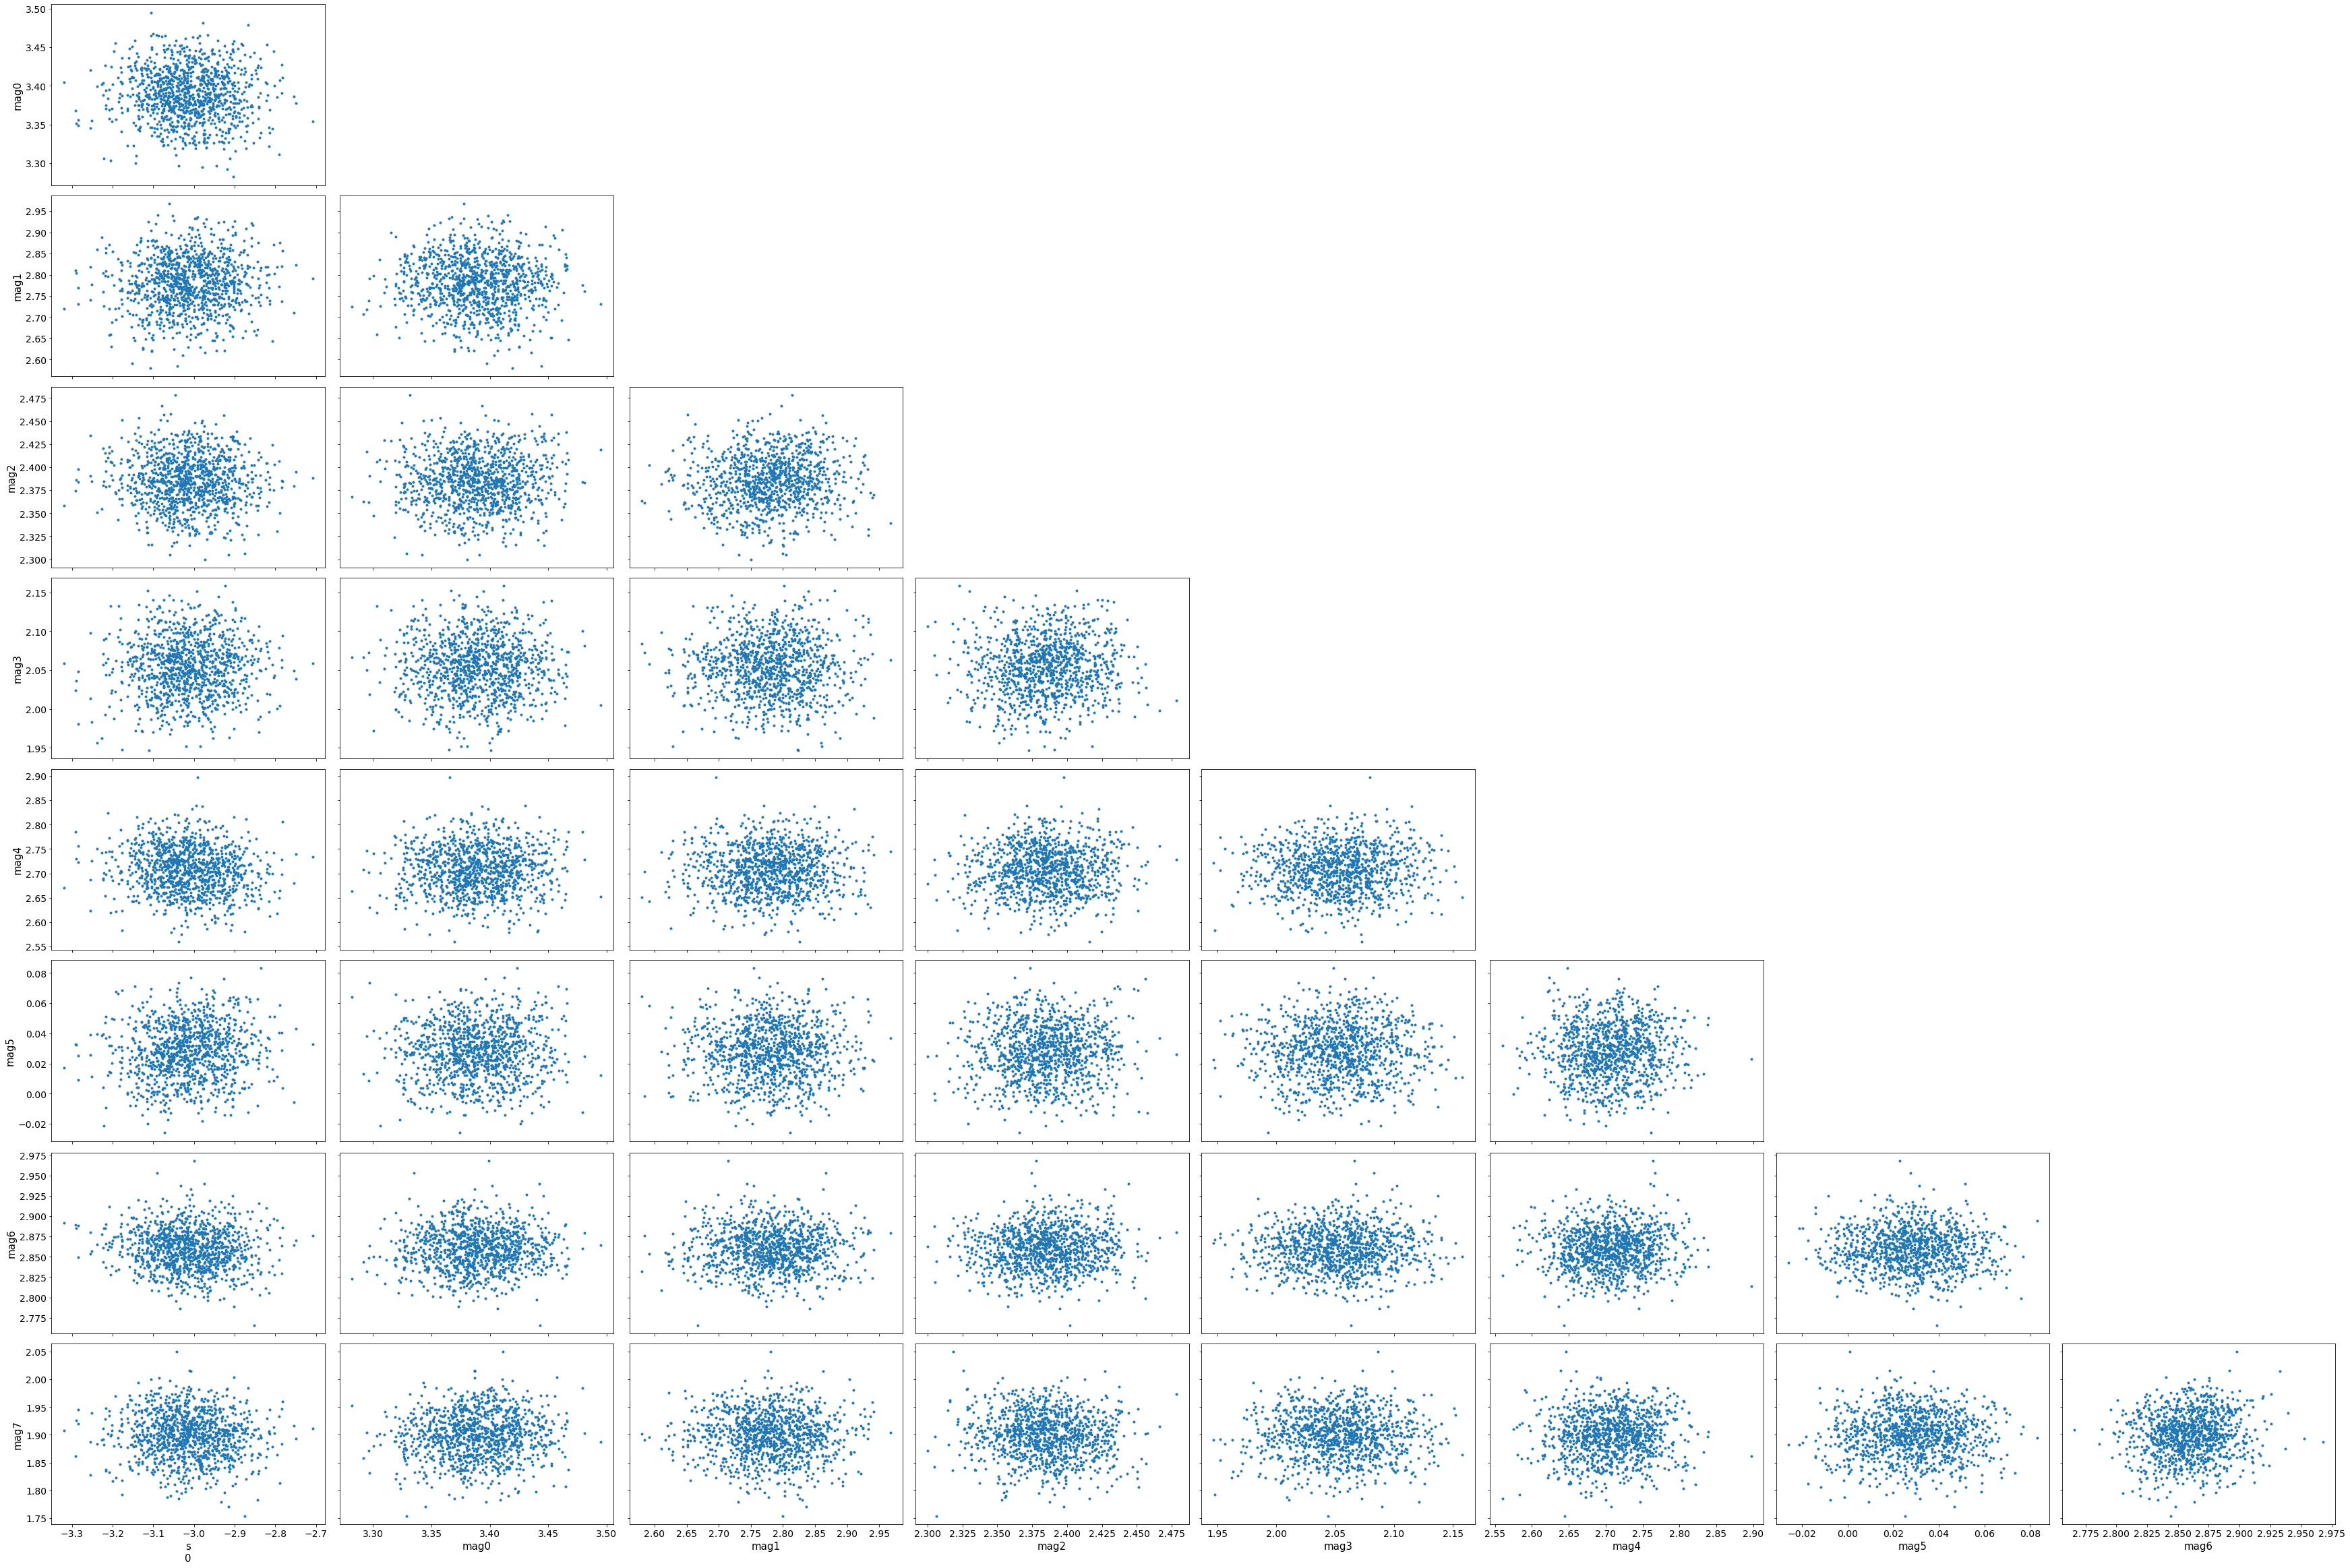

In [241]:
pm.pairplot(samples_g)

In [71]:
pm.summary(samples_g)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
s[0],-4.976,0.054,-5.077,-4.874,0.0,0.0,41236.0,41202.0,41287.0,30530.0,1.0
mag,29.016,0.021,28.978,29.054,0.0,0.0,42845.0,42845.0,42818.0,30439.0,1.0
sig_int,0.777,0.053,0.680,0.876,0.0,0.0,50540.0,49869.0,50735.0,29995.0,1.0


Text(0, 0.5, 'y')

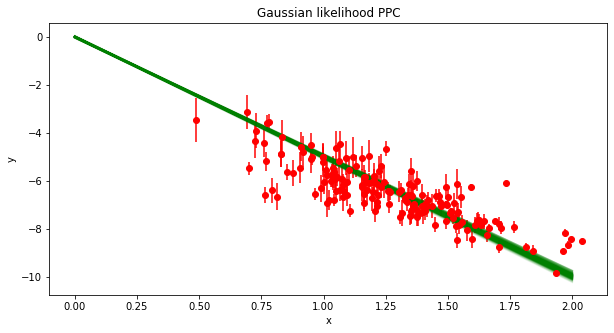

In [88]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

# draw 200 random samples from the posteriors
nsamp = 200
i = np.random.choice(range(samples_g['s'].shape[0]), size=nsamp)
m = samples_g['s'][i]
b = samples_g['mag'][i]


# plot the posterior predictive samples for the Gaussian
#for i in range(ppc['likelihood'].shape[0]):
#    ymod = ppc['likelihood'][i,:]
#    ax.plot(x, ymod, 'ko', alpha=0.01)
    


xarr = np.array([0.00, 2.00])
for mx, bx in zip(m, b):
    ax.plot(xarr, mx*xarr + bx-mag_est[5], alpha=0.1, color='green')
    
    
ax.errorbar(logP, mag_obs-mag_est[5], yerr=sig, linestyle='None', color='red', marker='o')

ax.set_title('Gaussian likelihood PPC')

ax.set_xlabel('x')
ax.set_ylabel('y')

In [117]:
# this is the real thing: (this is going to be a lot of repetitive work)


ceph.select(ceph.list_hosts()[0])
logP0 = ceph.logP
sig0 = ceph.sigma
mag_obs0 = ceph.mobs

ceph.select(ceph.list_hosts()[1])
logP1 = ceph.logP
sig1 = ceph.sigma
mag_obs1 = ceph.mobs

ceph.select(ceph.list_hosts()[2])
logP2 = ceph.logP
sig2 = ceph.sigma
mag_obs2 = ceph.mobs

ceph.select(ceph.list_hosts()[3])
logP3 = ceph.logP
sig3 = ceph.sigma
mag_obs3 = ceph.mobs

ceph.select(ceph.list_hosts()[4])
logP4 = ceph.logP
sig4 = ceph.sigma
mag_obs4 = ceph.mobs

ceph.select(ceph.list_hosts()[5])
logP5 = ceph.logP
sig5 = ceph.sigma
mag_obs5 = ceph.mobs

ceph.select(ceph.list_hosts()[6])
logP6 = ceph.logP
sig6 = ceph.sigma
mag_obs6 = ceph.mobs

ceph.select(ceph.list_hosts()[7])
logP7 = ceph.logP
sig7 = ceph.sigma
mag_obs7 = ceph.mobs

ceph.select(ceph.list_hosts()[8])
logP8 = ceph.logP
sig8 = ceph.sigma
mag_obs8 = ceph.mobs

sig_int_est=0.5

#mag_est[5]=pm.summary(samples_g)['mean'].values[1]

zpw = ceph.redshifts['4258']
vel = zpw*c 
dis = vel/H0*10**6 # in unit of pc
zpw = 5 * np.log10(dis/10)

with pm.Model() as model:
    s = pm.Normal('s', mu=-2.5, sigma=1, shape=1)
    
    mag0=pm.Normal('mag0', mu=mag_est[0], sigma=sig0)
    mag1=pm.Normal('mag1', mu=mag_est[1], sigma=sig1)
    mag2=pm.Normal('mag2', mu=mag_est[2], sigma=sig2)
    mag3=pm.Normal('mag3', mu=mag_est[3], sigma=sig3)
    mag4=pm.Normal('mag4', mu=mag_est[4], sigma=sig4)
    mag5=pm.Normal('mag5', mu=mag_est[5], sigma=sig5)
    mag6=pm.Normal('mag6', mu=mag_est[6], sigma=sig6)
    mag7=pm.Normal('mag7', mu=mag_est[7], sigma=sig7)
    mag8=pm.Normal('mag8', mu=mag_est[8], sigma=sig8)
    
    #z = pm.Normal('z', mu=zpw, sigma=5)
    
    sig_int=pm.TruncatedNormal('sig_int',mu=sig_int_est,sigma=1,lower=0.0)
    #sig_int=sig_int_est
    
    model0 = mag0 + s*(logP0)
    model1 = mag1 + s*(logP1)
    model2 = mag2 + s*(logP2)
    model3 = mag3 + s*(logP3)
    model4 = mag4 + s*(logP4)
    model5 = mag5 + s*(logP5)
    model6 = mag6 + s*(logP6)
    model7 = mag7 + s*(logP7)
    model8 = mag8 + s*(logP8)
    
    likelihood=pm.math.concatenate([
        pm.Normal('likelihood0', mu=model0, sigma=np.sqrt(sig0**2 + sig_int**2), observed=mag_obs0),
        pm.Normal('likelihood1', mu=model1, sigma=np.sqrt(sig1**2 + sig_int**2), observed=mag_obs1),
        pm.Normal('likelihood2', mu=model2, sigma=np.sqrt(sig2**2 + sig_int**2), observed=mag_obs2),
        pm.Normal('likelihood3', mu=model3, sigma=np.sqrt(sig3**2 + sig_int**2), observed=mag_obs3),
        pm.Normal('likelihood4', mu=model4, sigma=np.sqrt(sig4**2 + sig_int**2), observed=mag_obs4),
        pm.Normal('likelihood5', mu=model5, sigma=np.sqrt(sig5**2 + sig_int**2), observed=mag_obs5),
        pm.Normal('likelihood6', mu=model6, sigma=np.sqrt(sig6**2 + sig_int**2), observed=mag_obs6),
        pm.Normal('likelihood7', mu=model7, sigma=np.sqrt(sig7**2 + sig_int**2), observed=mag_obs7),
        pm.Normal('likelihood8', mu=model8, sigma=np.sqrt(sig8**2 + sig_int**2), observed=mag_obs8)])
    
    samples_t = pm.sample(10000,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig_int, mag8, mag7, mag6, mag5, mag4, mag3, mag2, mag1, mag0, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:34<00:00, 1213.85draws/s]


/home/thirty-oner/anaconda3/envs/fds/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/thirty-oner/anaconda3/envs/fds/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/thirty-oner/anaconda3/envs/fds/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/thirty-oner/anaconda3/envs/fds/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwarg

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee6e9a6ac8>,
      dtype=object)

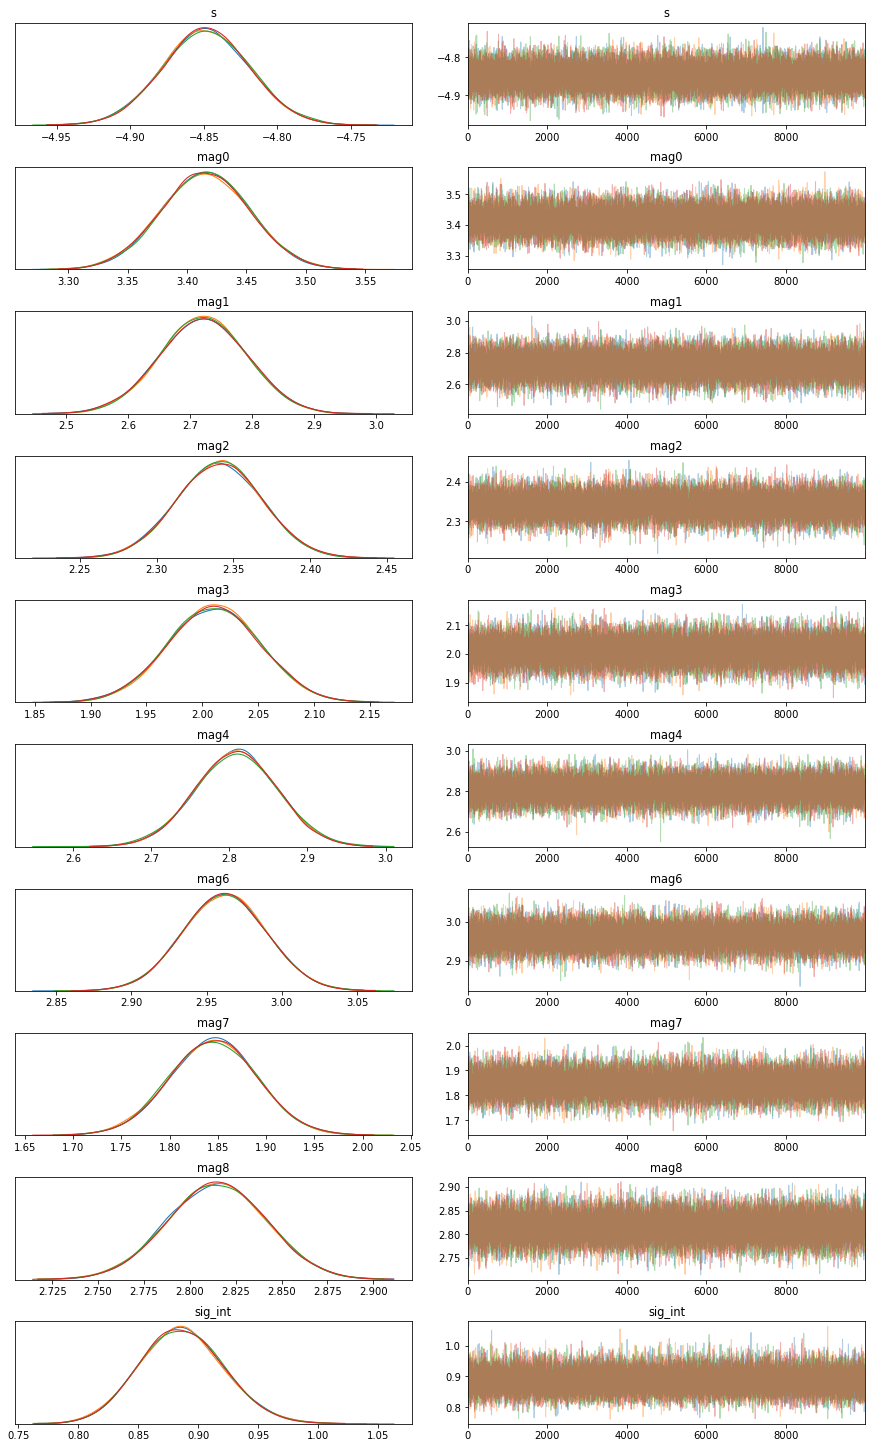

In [73]:
pm.traceplot(samples_t)

/home/thirty-oner/anaconda3/envs/fds/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/pairplot.py:90: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 9x9 grid
  SyntaxWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee7e4e62b0>,
      dtype=object)

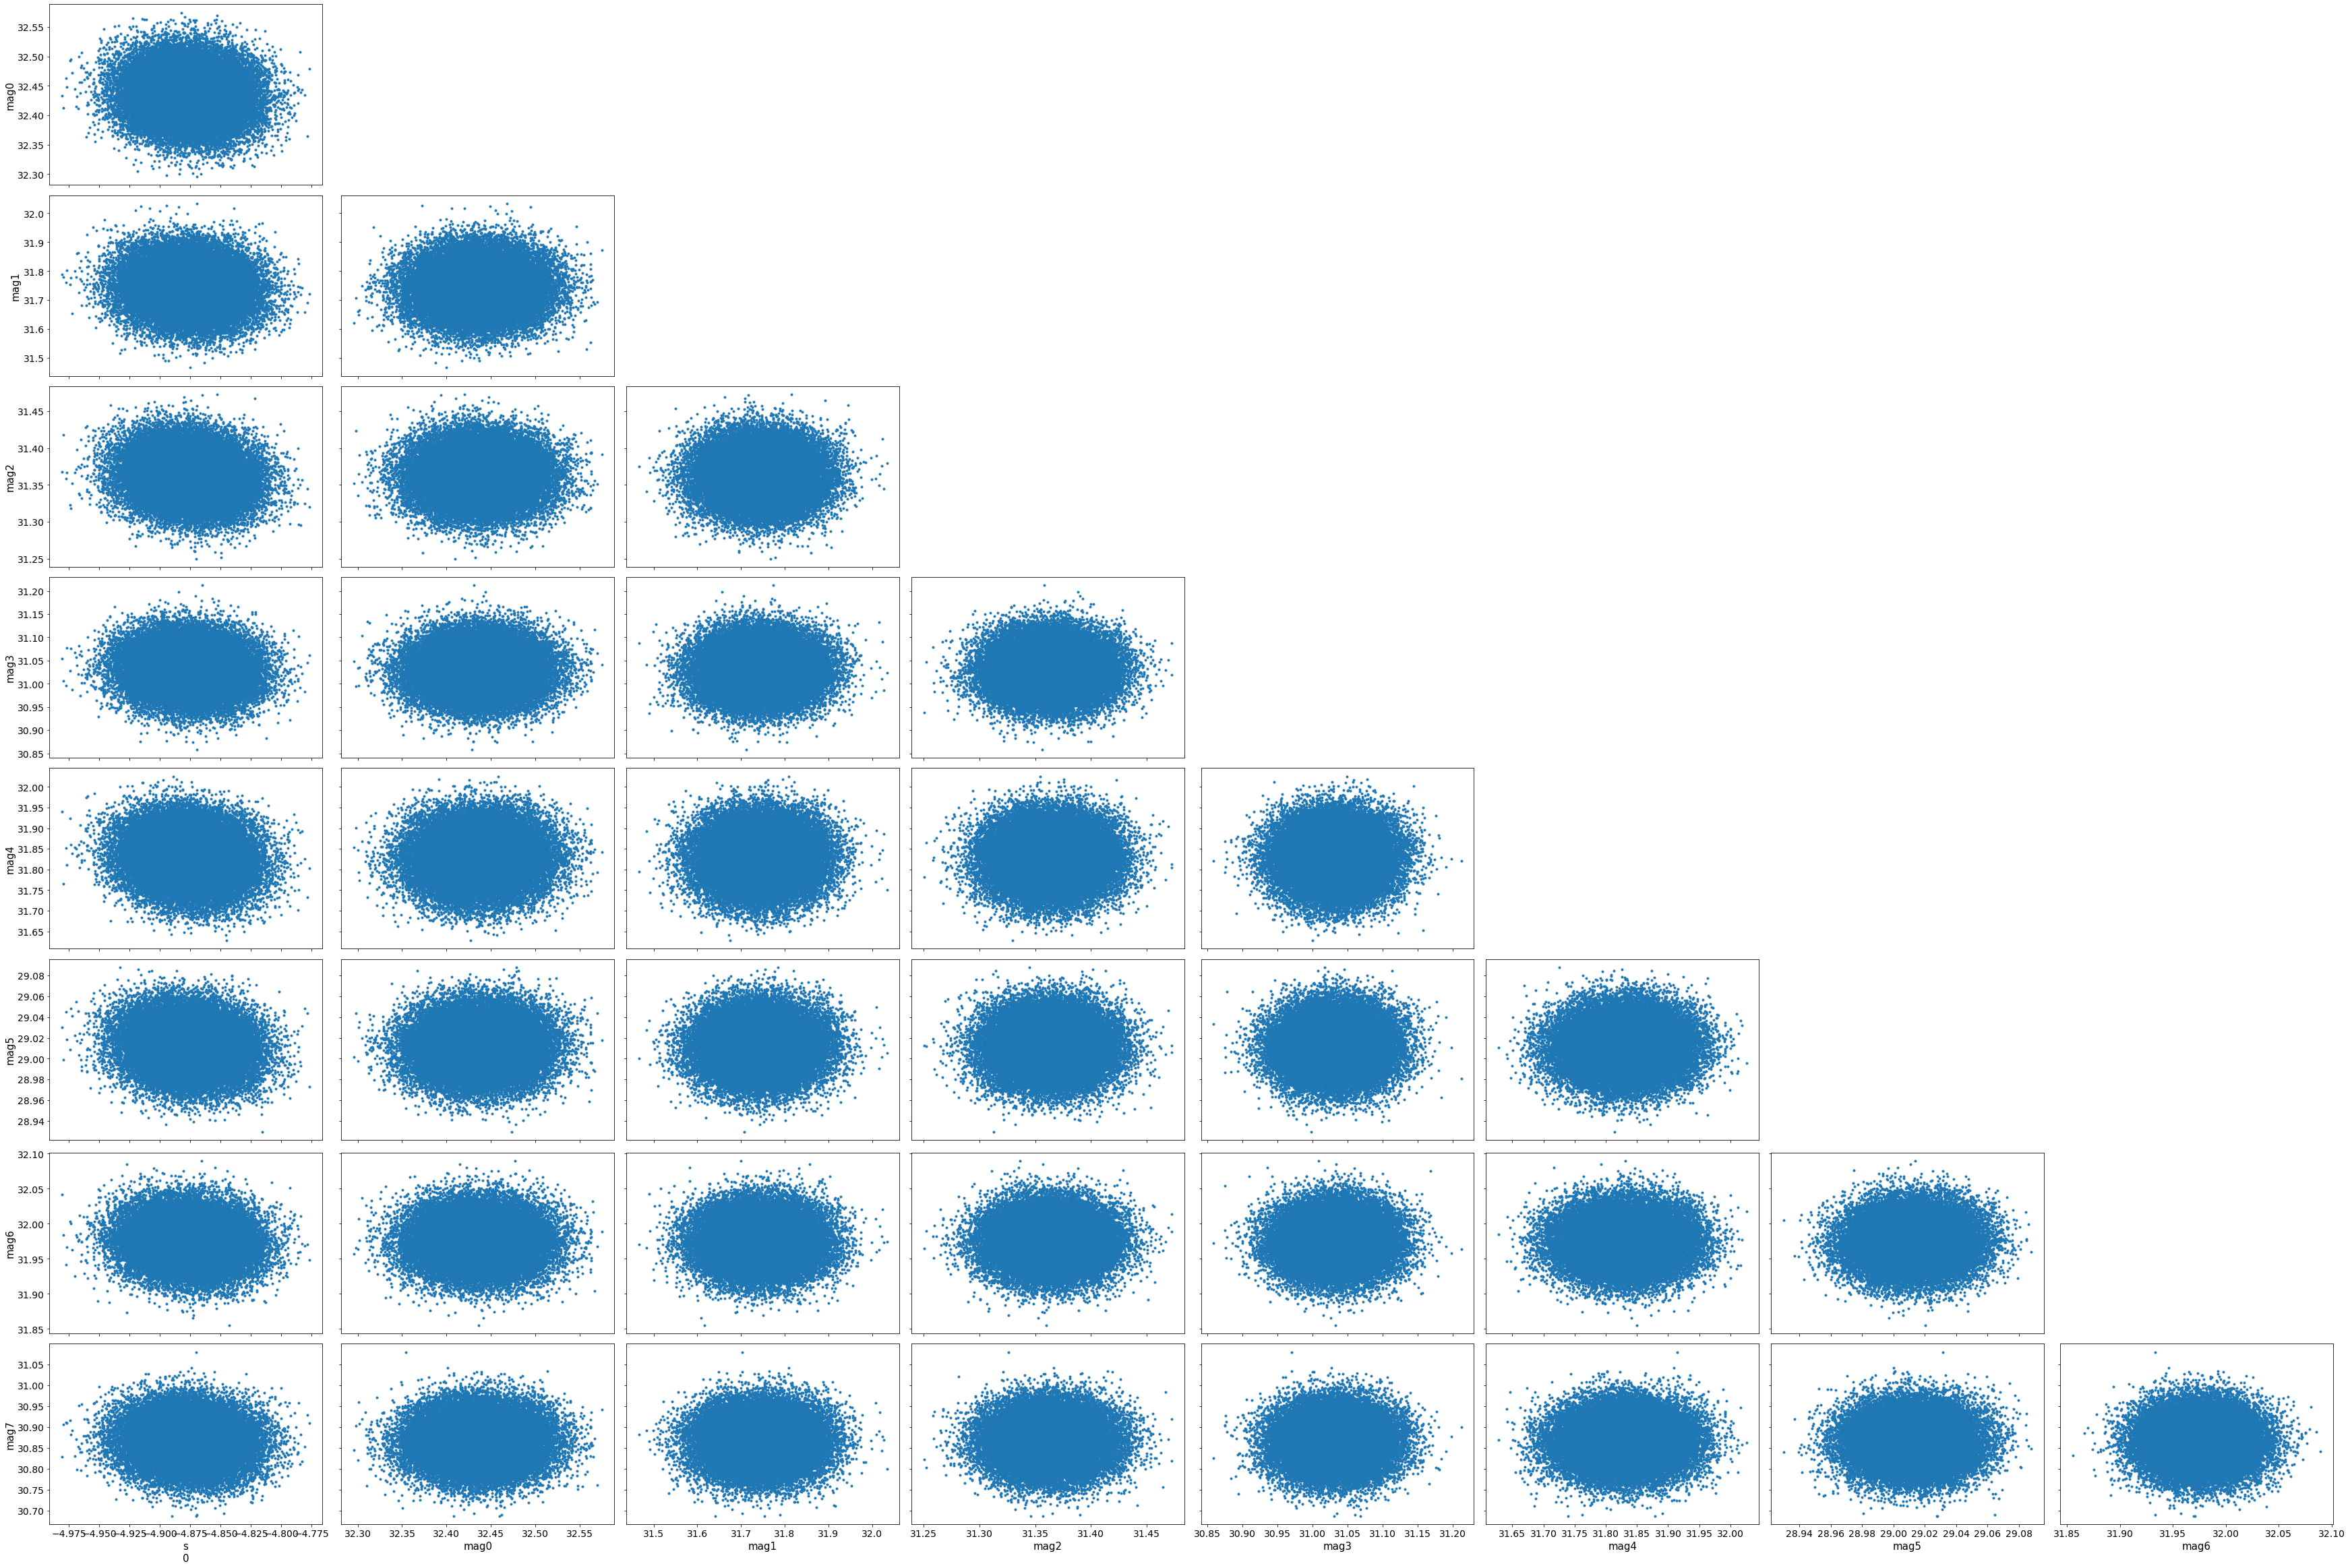

In [11]:
pm.pairplot(samples_t)

# sadly there is a max of 40 subplots allowed. I don't know how to change the max number for the package.

In [119]:
pm.summary(samples_t)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
s[0],-4.877,0.025,-4.924,-4.829,0.0,0.0,60827.0,60827.0,60821.0,32640.0,1.0
mag0,32.436,0.037,32.365,32.503,0.0,0.0,69314.0,69314.0,69286.0,31588.0,1.0
mag1,31.744,0.068,31.620,31.875,0.0,0.0,67163.0,67163.0,67173.0,29865.0,1.0
mag2,31.363,0.027,31.313,31.414,0.0,0.0,66452.0,66452.0,66444.0,31906.0,1.0
mag3,31.031,0.040,30.957,31.108,0.0,0.0,69403.0,69403.0,69459.0,31001.0,1.0
mag4,31.830,0.052,31.734,31.927,0.0,0.0,66985.0,66982.0,67018.0,31939.0,1.0
mag5,29.012,0.020,28.974,29.048,0.0,0.0,66217.0,66217.0,66217.0,30153.0,1.0
mag6,31.975,0.027,31.926,32.028,0.0,0.0,70145.0,70145.0,70061.0,32157.0,1.0
mag7,30.868,0.045,30.782,30.951,0.0,0.0,69355.0,69355.0,69416.0,30327.0,1.0
mag8,31.834,0.026,31.783,31.882,0.0,0.0,63679.0,63678.0,63752.0,29822.0,1.0


In [108]:
hosts = ceph.list_hosts()
hosts = np.delete(hosts,[5])
    
diff=[3.276,3.138,2.835,2.475,2.396,1.567,2.383,2.461]
mu_best=np.array([32.59,32.27,32.13,31.70,31.66,30.91,31.67,31.72])
print('data from the table 3 of the paper')
for n,dif in zip(hosts,mu_best):
    print(n,dif)

data from the table 3 of the paper
1309 32.59
3021 32.27
3370 32.13
3982 31.7
4038 31.66
4536 30.91
4639 31.67
5584 31.72


### Whether it be the likelihood function or our prior, the results from the simulation doesn't fit the table from the paper exactly. 

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

Equation 3:
$$ m_{v,i}^0 - (\mu_{0,i} - \mu_{0,4258}) = m_{v,4258}^0$$

Equation 4:
$$\log H_0 = \frac{(m_{v,4258}^0 - \mu_{0,4259}) + 5 a_v +25}{5}$$

Plugging Eq. 3 into Eq.4:
$$\log H_0 = \frac{(m_{v,i}^0 - (\mu_{0,i} - \mu_{0,4258})) - \mu_{0,4259} + 5 a_v +25}{5}$$



$$\log H_0 = \frac{m_{v,i}^0 + 5 a_v - \mu_{0,i} + 25}{5}$$

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

29.404067961403957
[-4.877 32.436 31.744 31.363 31.031 31.83  29.012 31.975 30.868 31.834
  0.858]
[32.436 31.744 31.363 31.031 31.83  31.975 30.868 31.834]


(array([1., 0., 0., 1., 1., 1., 0., 0., 2., 2.]),
 array([35.97380761, 41.45434803, 46.93488845, 52.41542887, 57.8959693 ,
        63.37650972, 68.85705014, 74.33759056, 79.81813098, 85.2986714 ,
        90.77921182]),
 <a list of 10 Patch objects>)

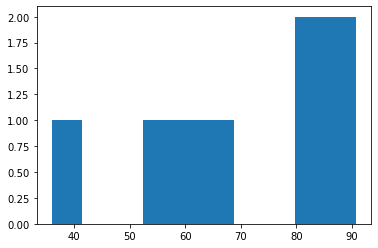

In [121]:
# NGC 4258 has a distance of 7.60 ± 0.17 (random) ± 0.15 (systematic) Mpc from Humphreys et al., 2013.
# 1309 3021 3370 3982 4038 4258 4536 4639 5584 for personal use. this is the order of the galaxy group in ceph.
# all data collected will be in order of above sequence


mu_5_h = 5*np.log10(7.6*10**6/10)
print(mu_5)
sigma_mu_5=np.sqrt(0.17**2+0.15**2)

mag_r=np.array([16.768,16.699, 16.545, 15.953, 15.901, 15.147, 16.040, 16.274])
mu=pm.summary(samples_t)['mean'].values
print(mu)
mu5=mu[6]
mu=np.delete(mu, [0,6,10], axis=0)
print(mu)
#mu=np.array([32.59,32.27,32.13,31.70,31.66,30.91,31.67,31.72])
#d_mu=np.array([3.276,3.138,2.835,2.475,2.396,1.567,2.383,2.461])

logH=(-(mu-mu5+mu_5_h)+mag_r+25)/5
H0=10**(logH)

plt.hist(H0)

In [122]:
H0[0,]

61.374279632076224

In [123]:
import scipy.stats as st
import statsmodels.api as sm

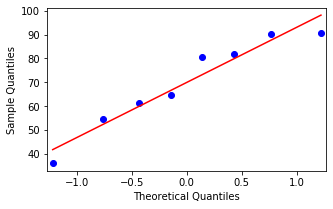

In [124]:
fig1 = plt.figure(figsize=(5, 3))
ax1 = fig1.add_subplot(111)

plot=sm.qqplot(H0, ax = ax1,line='r')

In [125]:
mean=np.mean(H0)
std=np.std(H0)

print(mean,std)

69.96509621370637 18.030851739339987


### From the QQPLOT, we can see that the calculated Hubble constant roughly follows a gaussian distribution, allowing me to extract the mean and standard deviation. 

The result of the simple statistic analysis is as follow:

$$ H_0 = 69.13 \pm 18.03\ (km/s)/Mpc$$